Idea is to load the csv.gz files and save them as a 'netcdf' file

In [1]:
# lets see how the current pv data is stored


import xarray as xr
import numpy as np
import fsspec
import io

filename = 'gs://solar-pv-nowcasting-data/PV/PVOutput.org/UK_PV_timeseries_batch.nc'

with fsspec.open(filename, mode="rb") as file:
    file_bytes = file.read()

with io.BytesIO(file_bytes) as file:
    pv_power = xr.open_dataset(file, engine="h5netcdf")
    
# xr of coords = datetime, and data variabes are all the different pv systems
print(pv_power)


/Users/peterdudfield/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


<xarray.Dataset>
Dimensions:   (datetime: 723828)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2010-12-15T13:10:00 ... 2019-08-20T23...
Data variables: (12/1481)
    10003     (datetime) float32 ...
    10012     (datetime) float32 ...
    10020     (datetime) float32 ...
    10033     (datetime) float32 ...
    10041     (datetime) float32 ...
    10078     (datetime) float32 ...
    ...        ...
    9757      (datetime) float32 ...
    9785      (datetime) float32 ...
    9807      (datetime) float32 ...
    9831      (datetime) float32 ...
    9860      (datetime) float32 ...
    9892      (datetime) float32 ...


In [2]:
# Lets try one file first

import fsspec
import pandas as pd
import time

file = "gs://solar-pv-nowcasting-data/PV/Passive/20211027_Passiv_PV_Data/5min/2021/Jan.csv.gz"
file_output = "./passive.netcdf"

t = time.time()
passive_5min_jan_df = pd.read_csv(file)


In [3]:
# change generation_wh to power_w
passive_5min_jan_df['power_w'] = passive_5min_jan_df['generation_wh'] / (5/60)
passive_5min_jan_df['datetime'] = pd.to_datetime(passive_5min_jan_df['timestamp'])

# pivot on ssid
passive_5min_jan_on_ssid = passive_5min_jan_df.pivot(index='datetime', columns='ss_id', values='power_w')
passive_5min_jan_on_ssid.columns = [str(col) for col in passive_5min_jan_on_ssid.columns]

# change to xarray
passive_5min_jan_xr = passive_5min_jan_on_ssid.to_xarray()

# change to float32
passive_5min_jan_xr = passive_5min_jan_xr.astype(np.float32)

# change tdatetime to 'datetime'
datetime = passive_5min_jan_on_ssid.index.tz_convert("UTC").tz_convert(None)
passive_5min_jan_xr['datetime'] = datetime

print(passive_5min_jan_xr)

<xarray.Dataset>
Dimensions:   (datetime: 8858)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2021-01-01 ... 2021-01-31T23:55:00
Data variables: (12/884)
    2607      (datetime) float32 nan nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    2626      (datetime) float32 nan nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    2631      (datetime) float32 nan nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    2657      (datetime) float32 nan nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    2660      (datetime) float32 nan nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    2760      (datetime) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    ...        ...
    27061     (datetime) float32 nan nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    27062     (datetime) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    27063     (datetime) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    27064     (datetime) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    27065 

In [7]:
# save to file
encoding = {name: {"compression": "lzf"} for name in passive_5min_jan_xr.data_vars}
passive_5min_jan_xr.to_netcdf(file_output, engine="h5netcdf", mode="w", encoding=encoding)

print(time.time() - t)


325.2580440044403


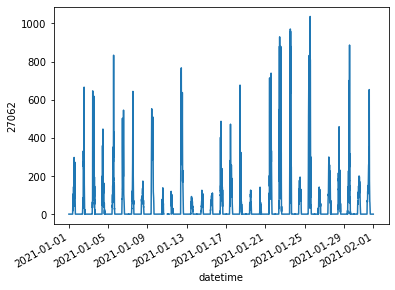

In [4]:
# plot
pd.options.plotting.backend = "plotly"
passive_5min_jan_xr['27062'].plot()